In [1]:
import torch
print("torch module path:", torch.__file__)
print(torch.cuda.is_available())
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, log_loss

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.preprocessing import StandardScaler


torch module path: c:\Users\Daria\anaconda3\Lib\site-packages\torch\__init__.py
False


In [2]:

data = pd.read_csv('Data/Final_data/final_bipolar_one_scaled_2')

data = data.iloc[:, 1:]
data.head()

,821,328813,823,817,818,239935,28116,351091,28118,1161942,...,103621,1596,638619,1244,78346,592978,86958,626947,bipolar,Bipolar
0,0.148812,0.001194,0.003473,0.006187,0.015304,0.005753,0.042440,0.054054,0.009226,0.000217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.097845,0.008707,0.013113,0.000000,0.004619,0.011520,0.012423,0.056169,0.001593,0.002495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.013404,0.009929,0.006619,0.000414,0.020602,0.001158,0.003310,0.012328,0.003392,0.000331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.082357,0.003270,0.003331,0.000000,0.017273,0.005367,0.010117,0.005614,0.003763,0.000123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.009274,0.000084,0.002951,0.011635,0.010370,0.272152,0.063148,0.001349,0.000506,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
class Model(nn.Module):
    def __init__(self, input_size, h1, h2, h3, output_size = 2):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, h1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(h3, output_size) 
        )
    def forward(self, x):
        return self.net(x)


In [4]:
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=10, h1=32, h2=16, h3=16, lr=0.01, num_epochs=100):
        self.input_size = input_size
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X, y):
        dataset = TensorDataset(X, y)
        
        val_size = int(0.2 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)

        self.model = Model(self.input_size, self.h1, self.h2, self.h3).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        best_loss = float('inf')
        patience = 20
        wait = 0
        best_state = None

        for epoch in range(self.num_epochs):
            self.model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                pred = self.model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    pred = self.model(xb)
                    val_loss += criterion(pred, yb).item()
                    

            val_loss /= len(val_loader)

            if val_loss < best_loss:
                best_loss = val_loss
                best_state = self.model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    #print(f"Early stopping at epoch {epoch+1}")
                    break

        #if best_state:
         #   self.model.load_state_dict(best_state)
        
        self.best_state_dict = best_state
   
        if self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)

        return self


    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
        return outputs.argmax(dim=1).cpu().numpy()
    
    def predict_proba(self, X):
        with torch.no_grad():
            outputs = self.model(X)
            probs = torch.softmax(outputs, dim=1)
            return probs.cpu().numpy()


In [5]:
param_grid = {
    'h1': [32, 64, 96, 128, 160],
    'h2': [16, 32, 64, 96],
    'h3': [16, 32, 64, 96],
    'lr': [0.0001, 0.0005],
    'num_epochs': [40, 60, 100, 120, 160, 200]
}

In [6]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
    #'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True) 
    #check loss calc
}

In [7]:
X = data.drop('Bipolar', axis = 1)
y = data['Bipolar']

X = X.values
y = y.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#X_train = torch.FloatTensor(X_train)
#X_test = torch.FloatTensor(X_test)

#y_train = torch.LongTensor(y_train)
#y_test = torch.LongTensor(y_test)

In [9]:

nested_scores = []
data_X = data.drop('Bipolar', axis = 1)
feature_names = data_X.columns.tolist()
N = 60
all_fprs = []
all_tprs = []
roc_auc_scores = []
top_features_per_fold = []

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, y):
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_test_cv = X[test_idx]
    y_test_cv = y[test_idx]

    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_test_cv = scaler.fit_transform(X_test_cv)

    X_train_cv = torch.FloatTensor(X_train_cv)
    y_train_cv = torch.LongTensor(y_train_cv)
    X_test_cv = torch.FloatTensor(X_test_cv)
    


    clf = GridSearchCV(SklearnWrapper(input_size=X.shape[1]), param_grid, cv=3, scoring='accuracy') #, n_jobs=-1
    clf.fit(X_train_cv, y_train_cv)

    with torch.no_grad():
        first_layer_weights = clf.best_estimator_.model.net[0].weight.detach().cpu().numpy()
        feature_importance = np.mean(np.abs(first_layer_weights), axis=0)
        top_feature_indices = np.argsort(feature_importance)[::-1][:N]
        top_feature_names = [feature_names[i] for i in top_feature_indices]

    #print("Top feature indices:", top_feature_indices)
    print("Top feature names:", top_feature_names)
    top_features_per_fold.append(top_feature_names)   

    preds = clf.predict(X_test_cv)
    acc = accuracy_score(y_test_cv, preds)
    nested_scores.append(acc)
    print(f"Fold Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test_cv, preds)
    print("Confusion Matrix:")
    print(cm)

    
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test_cv)[:, 1]
        roc_auc = roc_auc_score(y_test_cv, probs)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        roc_auc_scores.append(roc_auc)

        fpr, tpr, _ = roc_curve(y_test_cv, probs)
        all_fprs.append(fpr)
        all_tprs.append(tpr)
    else:
        print("ROC AUC Score: Not available (no probability prediction)")

print(f"Nested CV Mean Accuracy: {np.mean(nested_scores):.4f}")


Top feature names: ['415956', '40091', '46867', '1495', '290053', '255723', '29346', '58180', '43997', '36850', '99807', '232270', '395922', '392736', '305719', '634771', '1536', '118967', '39950', '36854', '376805', '53972', '626947', '29367', '332163', '1350067', '33033', '66219', '592978', '736', '1343', '28133', '1655', '314319', '863643', '1071880', '183', '1244', '638619', '29389', '310300', '649724', '47880', '454154', '86958', '52769', '216940', '339862', '316', '148814', '185293', '58134', '1309', '28901', '1408', '589437', '626935', '1134405', '1531', '89152']
Fold Accuracy: 0.8790
Confusion Matrix:
[[50  3]
 [12 59]]
ROC AUC Score: 0.9607
Top feature names: ['392736', '53972', '232270', '626947', '415956', '156974', '36850', '1495', '118967', '255723', '1501', '66219', '99807', '46867', '138595', '199', '638619', '2137', '89014', '634771', '384638', '882211', '736', '78346', '726', '589437', '1684', '1692', '1393', '58134', '46206', '745368', '33033', '282402', '2088', '1408

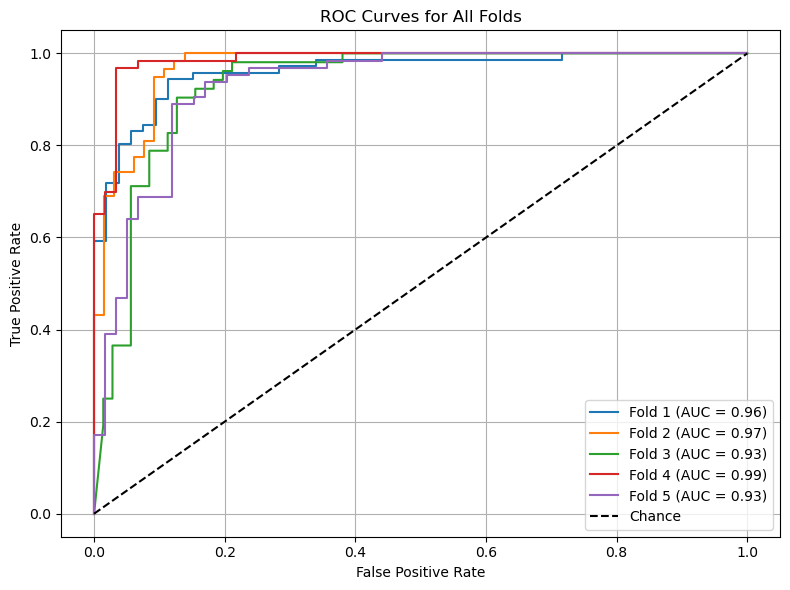

In [10]:
plt.figure(figsize=(8, 6))
for i in range(len(all_fprs)):
    plt.plot(all_fprs[i], all_tprs[i], label=f'Fold {i+1} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Folds')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
def features_in_k_arrays(arrays, k):
    if not arrays:
        return []

    counter = Counter()
    
    for array in arrays:
        unique_strings = set(array)  
        counter.update(unique_strings)
    
    return [string for string, count in counter.items() if count >= k]

In [12]:
k=4
common_features = features_in_k_arrays(top_features_per_fold, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")
k=3
common_features = features_in_k_arrays(top_features_per_fold, k)
print(f"\nFeatures appearing in at least {k} folds: {common_features} \n total length: {len(common_features)}")



Features appearing in at least 4 folds: ['29346', '626947', '232270', '634771', '255723', '1350067', '1655', '392736', '592978', '376805', '1495', '736', '58180', '589437', '339862', '99807', '638619', '36850', '395922', '40091', '118967', '66219', '415956', '53972', '46867', '1244', '156974', '78346', '1501', '831', '1692', '199', '1393'] 
 total length: 33

Features appearing in at least 3 folds: ['29346', '626947', '232270', '634771', '255723', '1350067', '1655', '392736', '592978', '305719', '376805', '1495', '33033', '736', '52769', '58180', '589437', '339862', '148814', '99807', '183', '332163', '638619', '36850', '395922', '40091', '43997', '118967', '66219', '415956', '53972', '1071880', '46867', '1536', '1244', '36849', '745368', '156974', '89014', '78346', '1501', '831', '1254', '1692', '199', '1580', '1393', '97084'] 
 total length: 48


In [13]:
print(clf.best_estimator_.model)

Model(
  (net): Sequential(
    (0): Linear(in_features=524, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
#m = clf.best_state_dict

In [14]:
best_model = clf.best_estimator_

In [15]:
correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test_cv):
    y_val = best_model.model.forward(data)

    print(f'{i+1}.)  {str(y_val)} \t {y_test_cv[i]} \t {y_val.argmax().item()}')

    # Correct or not
    if y_val.argmax().item() == y_test_cv[i]:
      correct +=1

print(f'We got {correct} correct!')
accuracy = correct / list(y_test_cv.shape)[0]
print(f'Accuracy is: {accuracy}')

1.)  tensor([ 6.0226, -4.0457]) 	 0.0 	 0
2.)  tensor([-3.3748,  3.7101]) 	 1.0 	 1
3.)  tensor([ 4.0114, -2.5724]) 	 0.0 	 0
4.)  tensor([12.3517, -8.4859]) 	 0.0 	 0
5.)  tensor([ 1.2893, -0.6952]) 	 1.0 	 0
6.)  tensor([ 3.5744, -2.3069]) 	 1.0 	 0
7.)  tensor([ 2.6900, -1.6867]) 	 0.0 	 0
8.)  tensor([ 6.7264, -4.4700]) 	 0.0 	 0
9.)  tensor([ 2.6513, -1.6095]) 	 0.0 	 0
10.)  tensor([ 7.6214, -5.0993]) 	 0.0 	 0
11.)  tensor([-3.5979,  4.0383]) 	 1.0 	 1
12.)  tensor([-3.5059,  3.8436]) 	 1.0 	 1
13.)  tensor([-1.0265,  1.2968]) 	 1.0 	 1
14.)  tensor([-1.6128,  1.8699]) 	 0.0 	 1
15.)  tensor([ 3.8502, -2.4789]) 	 0.0 	 0
16.)  tensor([ 1.2993, -0.5879]) 	 0.0 	 0
17.)  tensor([-1.2709,  1.5188]) 	 1.0 	 1
18.)  tensor([-1.9700,  2.1687]) 	 1.0 	 1
19.)  tensor([-1.8657,  2.0763]) 	 1.0 	 1
20.)  tensor([-3.2711,  3.6305]) 	 1.0 	 1
21.)  tensor([ 4.1284, -2.7053]) 	 0.0 	 0
22.)  tensor([-2.6555,  2.8889]) 	 1.0 	 1
23.)  tensor([ 8.2045, -5.5005]) 	 0.0 	 0
24.)  tensor([ 2.242

In [ ]:
print(list(y_test.shape))

NameError: name 'y_test' is not defined

In [ ]:
#torch.save(best_model.model.state_dict(), 'Models/3_layer_nn_96_64_64_with_dropout')

In [ ]:
#model = Model(input_size=X_train.shape[1], h1=160, h2=16, h3=16, output_size=2)
#model.load_state_dict(torch.load('Models/3_layer_nn_160_16_16'))
#model.eval()

In [ ]:
'''correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)

    print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

    # Correct or not
    if y_val.argmax().item() == y_test[i]:
      correct +=1

print(f'We got {correct} correct!')'''

"correct = 0\nwith torch.no_grad():\n  for i, data in enumerate(X_test):\n    y_val = model.forward(data)\n\n    print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')\n\n    # Correct or not\n    if y_val.argmax().item() == y_test[i]:\n      correct +=1\n\nprint(f'We got {correct} correct!')"